In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patheffects as pe

import networkx as nx
from scipy.sparse import issparse, coo_matrix, csr_matrix, csc_matrix
from scipy.sparse.linalg import eigsh
from openfermionpyscf import run_pyscf
from openfermion import MolecularData, get_fermion_operator
from openfermion.linalg import get_sparse_operator,  get_number_preserving_sparse_operator


In [15]:
def indices_with_N_and_Sz0(n_orbital, n_elec):
    """전자수=N 이면서 S_z=0 (interleaved: 짝수=alpha, 홀수=beta)"""
    idx = []
    for s in range(1 << n_orbital):
        if s.bit_count() != n_elec:
            continue
        n_alpha = sum((s >> i) & 1 for i in range(0, n_orbital, 2))  # 0,2,4,...
        n_beta  = sum((s >> i) & 1 for i in range(1, n_orbital, 2))  # 1,3,5,...
        if n_alpha == n_beta:
            idx.append(s)
    return np.array(idx, dtype=int)

def sparse_to_graph(A, *,
                    directed=False,
                    weight="value",   # "value" | "abs" | "binary"
                    symmetrize=True,  # 무향 그래프용: 패턴을 A + A.T로 합칠지
                    tol=0.0,          # |a_ij|<=tol 은 0 취급
                    keep_diagonal=False):
    """
    희소행렬 A -> NetworkX Graph/DiGraph 변환

    Parameters
    ----------
    A : scipy.sparse matrix (정방 추천)
    directed : bool
        True면 DiGraph, False면 Graph
    weight : {"value","abs","binary"}
        엣지 weight 설정 방법
        - "value": a_ij (실수/복소 가능; 복소는 실수부 사용 권장)
        - "abs"  : |a_ij|
        - "binary": 1 (연결만 표현)
    symmetrize : bool
        무향 그래프에서 A의 패턴을 A + A^T로 결합 (권장)
        directed=True 인 경우엔 무시됨
    tol : float
        임계값 이하 절댓값은 0으로 무시
    keep_diagonal : bool
        True면 i==j 항도 self-loop로 추가

    Returns
    -------
    G : nx.Graph or nx.DiGraph
    """
    if not issparse(A):
        raise ValueError("A must be a scipy.sparse matrix")
    # COO로 변환
    A = A.tocoo(copy=True)

    # tol 필터링
    if tol > 0:
        mask = np.abs(A.data) > tol
        A = coo_matrix((A.data[mask], (A.row[mask], A.col[mask])), shape=A.shape)

    # 대각 요소 처리
    if not keep_diagonal:
        mask = A.row != A.col
        A = coo_matrix((A.data[mask], (A.row[mask], A.col[mask])), shape=A.shape)

    # 무향이면 패턴 대칭화(권장): A <- A + A.T (중복은 합쳐짐)
    if not directed and symmetrize:
        AT = coo_matrix((A.data, (A.col, A.row)), shape=A.shape)
        A = (A + AT).tocoo()

    # 그래프 타입 선택
    G = nx.DiGraph() if directed else nx.Graph()
    G.add_nodes_from(range(A.shape[0]))  # 노드: 0..n-1

    # weight 설정
    if weight == "binary":
        # 동일 (i,j) 중복 합치기 위해 집계
        from collections import defaultdict
        edges = defaultdict(float)
        for i, j, v in zip(A.row, A.col, A.data):
            if not directed and i == j and not keep_diagonal:
                continue
            key = (i, j) if directed else (min(i, j), max(i, j))
            edges[key] = 1.0  # 존재만 표시
        for (i, j), w in edges.items():
            G.add_edge(i, j, weight=w)

    else:
        # "value" 또는 "abs"
        if weight == "abs":
            vals = np.abs(A.data)
        elif weight == "value":
            # 복소인 경우 실수부만 쓰고 싶다면 .real 사용
            # 필요에 따라 변경 가능: vals = np.real(A.data)
            vals = A.data
        else:
            raise ValueError("weight must be 'value', 'abs', or 'binary'")

        # 동일 엣지 중복 합치기(무향일 때 i<j 묶기)
        from collections import defaultdict
        edges = defaultdict(float)
        for i, j, v in zip(A.row, A.col, vals):
            if not directed and i == j and not keep_diagonal:
                continue
            key = (i, j) if directed else (min(i, j), max(i, j))
            edges[key] += float(v)  # 누적(합). 필요시 max/mean 등으로 변경 가능.

        for (i, j), w in edges.items():
            G.add_edge(i, j, weight=w)

    return G

In [16]:
def sparse_to_graph(A, *,
                    directed=False,
                    weight="value",   # "value" | "abs" | "binary"
                    symmetrize=True,  # 무향 그래프용: 패턴을 A + A.T로 합칠지
                    tol=0.0,          # |a_ij|<=tol 은 0 취급
                    keep_diagonal=False):
    """
    희소행렬 A -> NetworkX Graph/DiGraph 변환

    Parameters
    ----------
    A : scipy.sparse matrix (정방 추천)
    directed : bool
        True면 DiGraph, False면 Graph
    weight : {"value","abs","binary"}
        엣지 weight 설정 방법
        - "value": a_ij (실수/복소 가능; 복소는 실수부 사용 권장)
        - "abs"  : |a_ij|
        - "binary": 1 (연결만 표현)
    symmetrize : bool
        무향 그래프에서 A의 패턴을 A + A^T로 결합 (권장)
        directed=True 인 경우엔 무시됨
    tol : float
        임계값 이하 절댓값은 0으로 무시
    keep_diagonal : bool
        True면 i==j 항도 self-loop로 추가

    Returns
    -------
    G : nx.Graph or nx.DiGraph
    """
    if not issparse(A):
        raise ValueError("A must be a scipy.sparse matrix")
    # COO로 변환
    A = A.tocoo(copy=True)

    # tol 필터링
    if tol > 0:
        mask = np.abs(A.data) > tol
        A = coo_matrix((A.data[mask], (A.row[mask], A.col[mask])), shape=A.shape)

    # 대각 요소 처리
    if not keep_diagonal:
        mask = A.row != A.col
        A = coo_matrix((A.data[mask], (A.row[mask], A.col[mask])), shape=A.shape)

    # 무향이면 패턴 대칭화(권장): A <- A + A.T (중복은 합쳐짐)
    if not directed and symmetrize:
        AT = coo_matrix((A.data, (A.col, A.row)), shape=A.shape)
        A = (A + AT).tocoo()

    # 그래프 타입 선택
    G = nx.DiGraph() if directed else nx.Graph()
    G.add_nodes_from(range(A.shape[0]))  # 노드: 0..n-1

    # weight 설정
    if weight == "binary":
        # 동일 (i,j) 중복 합치기 위해 집계
        from collections import defaultdict
        edges = defaultdict(float)
        for i, j, v in zip(A.row, A.col, A.data):
            if not directed and i == j and not keep_diagonal:
                continue
            key = (i, j) if directed else (min(i, j), max(i, j))
            edges[key] = 1.0  # 존재만 표시
        for (i, j), w in edges.items():
            G.add_edge(i, j, weight=w)

    else:
        # "value" 또는 "abs"
        if weight == "abs":
            vals = np.abs(A.data)
        elif weight == "value":
            # 복소인 경우 실수부만 쓰고 싶다면 .real 사용
            # 필요에 따라 변경 가능: vals = np.real(A.data)
            vals = A.data
        else:
            raise ValueError("weight must be 'value', 'abs', or 'binary'")

        # 동일 엣지 중복 합치기(무향일 때 i<j 묶기)
        from collections import defaultdict
        edges = defaultdict(float)
        for i, j, v in zip(A.row, A.col, vals):
            if not directed and i == j and not keep_diagonal:
                continue
            key = (i, j) if directed else (min(i, j), max(i, j))
            edges[key] += float(v)  # 누적(합). 필요시 max/mean 등으로 변경 가능.

        for (i, j), w in edges.items():
            G.add_edge(i, j, weight=w)

    return G

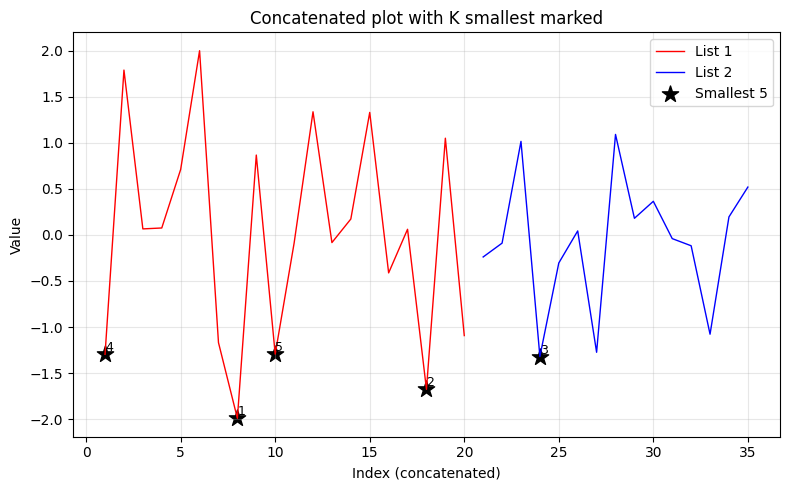

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def is_hermitian(A, tol=1e-10):
    if np.iscomplexobj(A):
        return np.allclose(A, A.conj().T, atol=tol)
    else:
        return np.allclose(A, A.T, atol=tol)

def to_dense(A):
    try:
        from scipy.sparse import spmatrix
        if isinstance(A, spmatrix):
            return A.toarray()
    except Exception:
        pass
    return A

def eigenvalues_sorted_asc(A, assume_hermitian=None):
    """
    모든 고유값을 오름차순 정렬하여 반환.
    """
    A = to_dense(A)
    if assume_hermitian is None:
        herm = is_hermitian(A)
    else:
        herm = bool(assume_hermitian)

    if herm:
        w = np.linalg.eigh(A)[0]
        w = np.real_if_close(w, tol=1000)
    else:
        w = np.linalg.eigvals(A)

    if np.iscomplexobj(w):
        idx = np.argsort(np.abs(w))  # 절댓값 기준 오름차순
        w_sorted = w[idx]
    else:
        w_sorted = np.sort(w)  # 그냥 오름차순
    return w_sorted

def plot_eigenvalues_asc(A, assume_hermitian=None, mode="auto", title=None):
    """
    고유값을 오름차순으로 플로팅.
    """
    w_sorted = eigenvalues_sorted_asc(A, assume_hermitian=assume_hermitian)

    if mode == "auto":
        if np.iscomplexobj(w_sorted):
            y = np.abs(w_sorted)
            y_label = r"$|\lambda|$ (magnitude)"
        else:
            y = np.real(w_sorted)
            y_label = r"$\lambda$"
    elif mode == "real":
        y = np.real(w_sorted)
        y_label = r"Re($\lambda$)"
    elif mode == "abs":
        y = np.abs(w_sorted)
        y_label = r"$|\lambda|$"
    else:
        raise ValueError("mode는 'auto'|'real'|'abs' 중 하나여야 합니다.")

    x = np.arange(1, len(y) + 1)
    return y

def plot_two_lists_readable(
    list1, list2, k=5,
    color1='red', color2='blue',
    star_color='black', star_edge='white',
    title='Concatenated plot with K smallest marked (readable)'
):
    a1 = np.asarray(list1).ravel()
    a2 = np.asarray(list2).ravel()

    # x 범위 (이어 붙이기)
    x1 = np.arange(1, len(a1) + 1)
    x2 = np.arange(len(a1) + 1, len(a1) + len(a2) + 1)

    # 전체 배열
    x_all = np.concatenate([x1, x2])
    y_all = np.concatenate([a1, a2])

    # k개 선택 (NaN 안전)
    valid = np.isfinite(y_all)
    xv = x_all[valid]
    yv = y_all[valid]
    k_eff = min(k, yv.size)
    idx_k = np.argpartition(yv, k_eff - 1)[:k_eff]
    idx_k = idx_k[np.argsort(yv[idx_k])]  # 값 오름차순(1위가 가장 작음)

    # 그림
    plt.figure(figsize=(10, 5.6), dpi=120)
    ax = plt.gca()

    # 구간 배경 (리스트1, 리스트2 영역 구분)
    ax.axvspan(x1.min()-0.5, x1.max()+0.5, color=color1, alpha=0.06, lw=0)
    ax.axvspan(x2.min()-0.5, x2.max()+0.5, color=color2, alpha=0.06, lw=0)

    # 곡선
    ax.plot(x1, a1, color=color1, lw=1.8, marker='o', ms=2.5, label='List 1', zorder=2)
    ax.plot(x2, a2, color=color2, lw=1.8, marker='o', ms=2.5, label='List 2', zorder=2)

    # k개 별 표시(흰 테두리)
    ax.scatter(xv[idx_k], yv[idx_k],
               s=160, marker='*', c=star_color,
               edgecolors=star_edge, linewidths=1.4,
               zorder=4, label=f'Smallest {k_eff}')

    # 주석: 순위 숫자 + 흰색 외곽선(시인성)
    for rank, (xx, yy) in enumerate(zip(xv[idx_k], yv[idx_k]), start=1):
        # 값이 겹치지 않게 약간 오른쪽/위로 오프셋
        ax.annotate(f'{rank}',
                    xy=(xx, yy), xytext=(6, 6),
                    textcoords='offset points',
                    fontsize=10, color='black',
                    path_effects=[pe.withStroke(linewidth=2.5, foreground='white')],
                    zorder=5)

    # 레이블/범례/그리드
    ax.set_title(title, fontsize=14, pad=10)
    ax.set_xlabel('Index (concatenated)', fontsize=12)
    ax.set_ylabel('Value', fontsize=12)
    ax.grid(True, which='major', alpha=0.25)
    ax.tick_params(labelsize=10)

    # 좌측/우측 구간 레이블(상단)
    ax.text((x1.min()+x1.max())/2, 0.98, 'List 1 region', transform=ax.get_xaxis_transform(),
            ha='center', va='top', fontsize=10, color=color1,
            path_effects=[pe.withStroke(linewidth=2, foreground='white')])
    ax.text((x2.min()+x2.max())/2, 0.98, 'List 2 region', transform=ax.get_xaxis_transform(),
            ha='center', va='top', fontsize=10, color=color2,
            path_effects=[pe.withStroke(linewidth=2, foreground='white')])

    # 범례를 밖으로
    ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)

    # y 여백 살짝(별/주석이 잘 보이게)
    ypad = 0.05 * (np.nanmax(y_all) - np.nanmin(y_all) + 1e-12)
    ax.set_ylim(np.nanmin(y_all) - ypad, np.nanmax(y_all) + ypad)

    plt.tight_layout()
    plt.show()


### 행렬만들기

In [ ]:
dist = 1.322
geometry = [('H', (0., 0., 0.)),
            ('H', (dist, 0., 0. )),
            ('H', (2*dist, 0., 0. )),
            ('H', (3*dist, 0., 0.)),
            ('H', (4*dist, 0., 0.)),
            ('H', (5*dist, 0., 0. )),
            ('H', (6*dist, 0., 0. )),
            ('H', (7*dist, 0., 0.))]

basis = 'sto-3g'
mol = MolecularData(geometry, basis, multiplicity=1, charge=0)
mol = run_pyscf(mol, run_scf=1, run_fci=0)
# 3. 2차 정량화 Hamiltonian 얻기
ham_int = mol.get_molecular_hamiltonian()
ham_fci = get_fermion_operator(ham_int)     
#H = get_sparse_operator(ham_fci, n_qubits=mol.n_qubits)
H = get_number_preserving_sparse_operator(
fermion_op=ham_fci,
num_qubits=mol.n_qubits,
num_electrons=mol.n_electrons,       # 필수
spin_preserving=True ,        # S_z 고정 (필요 없으면 None)
reference_determinant=None,
excitation_level=None)
print(H)
H_real = H.real

<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 903620 stored elements and shape (4900, 4900)>
  Coords	Values
  (0, 0)	-3.877659939242638
  (1, 0)	-9.090024362000057e-08
  (3, 0)	-2.016156076534159e-07
  (6, 0)	3.920739031354481e-07
  (8, 0)	-2.409115032360465e-07
  (9, 0)	-4.222474286191824e-07
  (11, 0)	3.445307003094311e-07
  (14, 0)	-5.558312561500245e-07
  (16, 0)	-1.0334457863254987e-08
  (17, 0)	9.090024361653112e-08
  (19, 0)	2.016156076534159e-07
  (22, 0)	-3.920739031510606e-07
  (24, 0)	2.409115032360465e-07
  (25, 0)	4.2224742862091713e-07
  (27, 0)	-3.4453070031290056e-07
  (30, 0)	5.558312561482898e-07
  (32, 0)	1.0334457863254987e-08
  (33, 0)	0.012712866861269375
  (35, 0)	-0.0031040559609460186
  (36, 0)	0.009103937446508463
  (38, 0)	0.006281105225374579
  (40, 0)	-0.015967959472287706
  (43, 0)	-0.011699560563175622
  (45, 0)	-0.002189434591530848
  (47, 0)	0.023959255225930013
  :	:
  (4852, 4899)	0.023959255225930013
  (4854, 4899)	-0.002189434591

### 행렬 히트맵 확인용

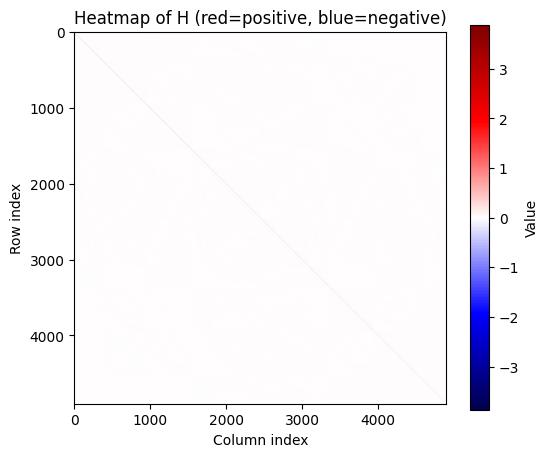

In [18]:
H_dense = H_real.toarray()
# 2) 히트맵 그리기
plt.figure(figsize=(6,5))

# 값 크기에 맞게 대칭적인 색범위 설정
vmax = np.abs(H_dense).max()

im = plt.imshow(H_dense, cmap='seismic', vmin=-vmax, vmax=vmax)
plt.colorbar(im, label="Value")

plt.title("Heatmap of H (red=positive, blue=negative)")
plt.xlabel("Column index")
plt.ylabel("Row index")
plt.show()

### 그래프 표현(무향)

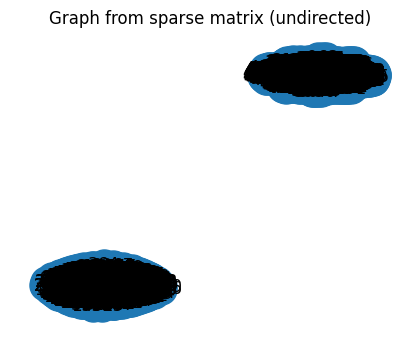

In [19]:
G = sparse_to_graph(H_real, directed=False, weight="abs", symmetrize=True, tol=0.0)
ccs = list(nx.connected_components(G))

subgraphs = [G.subgraph(S).copy() for S in ccs]

pos = nx.spring_layout(G, seed=0)
edge_w = [d["weight"] for *_, d in G.edges(data=True)]

plt.figure(figsize=(4,3))
nx.draw(G, pos, with_labels=True, node_size=500, width=edge_w)  # weight를 두께로
plt.title("Graph from sparse matrix (undirected)")
plt.show()

### 에너지 계산

In [20]:
sub_mat_idx_g = list(ccs[0])
H_sub_g = H[sub_mat_idx_g, :][:, sub_mat_idx_g]
print(H_sub_g)
eigval_g, eigvec = eigsh(H_sub_g, k=1, which='SA')
E_g = eigval_g[0]

sub_mat_idx_e = list(ccs[1])
H_sub_e = H[sub_mat_idx_e, :][:, sub_mat_idx_e]
print(H_sub_e)
eigval_e, eigvec = eigsh(H_sub_e, k=1, which='SA')
E_e = eigval_e[0]

print("Ground_state_Energy : ", E_g)
print("1st_Excited_Energy : ", E_e)

<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 458308 stored elements and shape (2468, 2468)>
  Coords	Values
  (0, 0)	-3.877659939242638
  (1, 0)	-9.090024362000057e-08
  (2, 0)	-2.016156076534159e-07
  (3, 0)	3.920739031354481e-07
  (4, 0)	-2.409115032360465e-07
  (5, 0)	-4.222474286191824e-07
  (6, 0)	3.445307003094311e-07
  (7, 0)	-5.558312561500245e-07
  (8, 0)	-1.0334457863254987e-08
  (9, 0)	9.090024361653112e-08
  (10, 0)	2.016156076534159e-07
  (11, 0)	-3.920739031510606e-07
  (12, 0)	2.409115032360465e-07
  (13, 0)	4.2224742862091713e-07
  (14, 0)	-3.4453070031290056e-07
  (15, 0)	5.558312561482898e-07
  (16, 0)	1.0334457863254987e-08
  (17, 0)	0.012712866861269375
  (18, 0)	-0.0031040559609460186
  (19, 0)	0.009103937446508463
  (20, 0)	0.006281105225374579
  (21, 0)	-0.015967959472287706
  (22, 0)	-0.011699560563175622
  (23, 0)	-0.002189434591530848
  (24, 0)	0.023959255225930013
  :	:
  (2443, 2467)	0.023959255225930013
  (2444, 2467)	-0.0021894345915308

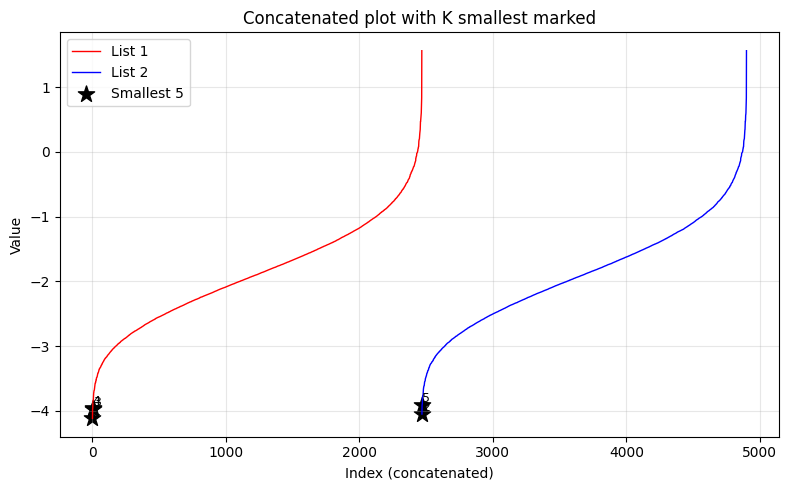

In [ ]:
e_grounds = eigenvalues_sorted_asc(H_sub_g)  # 자동 Hermitian 판정
e_1st_exc = eigenvalues_sorted_asc(H_sub_e)
list1 = e_grounds
list2 = e_1st_exc
plot_two_lists_readable(list1, list2, k=5)   